# _*Qiskit Aqua: Amplitude Estimation algorithms - comparison*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Dmitry Grinko<sup>[1,2,3]</sup>, Julien Gacon<sup>[1,2]</sup>, Christa Zoufal<sup>[1,2]</sup>, Stefan Woerner<sup>[2]</sup>
### Affliation
- <sup>[1]</sup>ETH Zürich
- <sup>[2]</sup>IBM Research
- <sup>[3]</sup>University of Geneva

### Iterative Quantum Amplitude Estimation - description
<br>
This notebook illustrates Iterative Amplitude Estimation [3] in the simplest case, where the (assumed to be unkown) success probability $a$ of a Bernoulli random variable is estimated. This algorithm can be viewed as an imporved version of the Canonical Amplitude Estimation, which is used in [1] and described in tutorial on Amplitude Estimation.
<br>
<br>
Amplitude estimation uses two operators: $A$ and $Q$, where $A$ describes the problem and $Q$ is derived from $A$ [2]. We are going to use the convetion $\theta \in [0,1]$.
Main oracle in our simplified case is $A = R_y(2 \cdot 2\pi\theta)$, i.e., it is a rotation with an angle $2\pi\theta = \sin^{-1}(\sqrt{a})$ around the Y-axis. For this single qubit case, $Q$ can  be represented by a Y-rotation around twice that angle, i.e., $Q = R_y(2 \cdot 2\pi \cdot 2\theta)$ [1].
In particular, this implies that powers of the operator can be efficiently represented, i.e. $Q^{m_i} = R_y(2 \cdot 2\pi \cdot 2m_i\theta)$.
<br>
<br>
The key idea of the Iterative Amplitude Estimation is to sequentially measure a circuit with different powers  $m_k$ of the $Q$ operator. The data obtained at each sebsequent round lowers the estimated error of the parameter $\theta$. The intuition why that works is as follows. Higher powers $m_i$ of the $Q$ operator allows to measure the probability $$ p = \frac{1-\cos(K_i 2\pi\theta)}{2} $$ by counting '1' outcomes, where $K_i = 2(2m_i+1)$. This data gives access to the bits of less significance in the binary expansion of $\theta$, since the multiplication of $\theta$ by an integer $K_i$ is done modulo 1: we know only the fractional part $\{ K_i \cdot \theta \}$ of the $K \cdot \theta$ by constructing the estimate $\cos(2\pi K_i \cdot \theta)$ from measured probability.
<br>
<br>
Given that the estimate of our parameter $\hat{\theta}$ on $i^{th}$ round is $\hat{\theta} \in [\theta^{min}_i,\theta^{max}_i]$, how do we find $m_{i+1}$ for the next round to make our cofidence interval smaller? Answer: we need to find the the largest $m_{i+1}$ such that the extrapolated interval $\frac{K_{i+1}}{K_i} \cdot [\theta^{min}_i,\theta^{max}_i]$ lies either in bottom or top halfplane: in that case the value of $\{ K_{i+1} \cdot \theta \}$ can be estimated entirely from the cosine data $\cos(2\pi K_{i+1} \cdot \theta)$ and knowledge of the location of the previous interval $[\theta^{min}_i,\theta^{max}_i]$. The procedure for this is implemented as internal method of the class $\textit{IterativeAmplitudeEstimation}$ and called $\textit{find_next_K}$

<br>
[1] <a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>
<br>
[2] <a href="https://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Brassard et al. 2000.</a>
<br>
[3] <a href="https://arxiv.org/abs/1912.05559">Iterative Quantum Amplitude Estimation. Grinko et al. 2019.</a>
<br>

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

import qiskit
from qiskit import BasicAer
from qiskit.aqua.algorithms.single_sample.amplitude_estimation.q_factory import QFactory
from qiskit.aqua.components.uncertainty_problems import UncertaintyProblem
from qiskit.aqua.algorithms.single_sample.amplitude_estimation.iqae import IterativeAmplitudeEstimation

In [18]:
# the probability and corresponding theta value to be recovered
probability = 0.3
theta = np.arcsin(np.sqrt(probability))/2/pi
print('theta =',theta)
print('2*pi*theta =',2*pi*theta)

theta = 0.09225252989138634
2*pi*theta = 0.5796397403637042


In [19]:
# define our toy oracles
class BernoulliAFactory(UncertaintyProblem):
    """
    Circuit Factory representing the operator A.
    """
    
    def __init__(self, probability=0.5):
        # 
        super().__init__(1)
        self._probability = probability
        self.i_state = 0
        self._theta = np.arcsin(np.sqrt(probability))/2/pi
    
    def build(self, qc, q, q_ancillas=None):
        
        # A is a rotation of angle 2*pi*theta around the Y-axis
        qc.ry(2*self._theta*2*pi, q[self.i_state])


class BernoulliQFactory(QFactory):
    """
    Circuit Factory representing the operator Q.
    This implementation exploits the fact that powers of Q can be implemented efficiently by just multiplying the angle.
    (iterative amplitude estimation only requires powers of Q, thus, only this method is overridden.)
    """
    
    def __init__(self, bernoulli_expected_value):
        super().__init__(bernoulli_expected_value, i_objective=0)
    
    def build(self, qc, q, q_ancillas=None):
        i_state = self.a_factory.i_state
        theta = self.a_factory._theta
        # Q is a rotation of angle 2*theta*2*pi around the Y-axis
        qc.ry(4*theta*2*pi, q[i_state])
        
    def build_power(self, qc, q, power, q_ancillas=None):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta
        qc.ry( 4*theta*power*2*pi, q[i_state])    

In [20]:
# construct factories for A and Q
bernoulli_a_factory = BernoulliAFactory(probability)
bernoulli_q_factory = BernoulliQFactory(bernoulli_a_factory)

In [58]:
# set the desired precision of the estimation and number of shots per round
epsilon = 1e-10
shots = 100
alpha = 0.05

# construct the iterative amplitude estimation
# here, we override the standard construction of Q since we know a more efficient way
# (exploiting the fact that A and Q are just Y-rotations)
iae = IterativeAmplitudeEstimation(epsilon, alpha, a_factory = bernoulli_a_factory, q_factory = bernoulli_q_factory)

In [59]:
#result = iae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))
result_iae = iae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=shots)

In [60]:
#let's look at the result of the algorithm
result_iae

{'a_interval': [[0, 1],
  [0.18389633939952063, 0.4817100833560212],
  [0.22513278560655556, 0.4373751768431325],
  [0.2684290474329756, 0.44522354124564284],
  [0.2860245453458039, 0.3885015886994553],
  [0.281490502386846, 0.314470089718792],
  [0.2954233665169619, 0.3049931197937248],
  [0.29848375244868314, 0.3010631940919009],
  [0.29965093880094396, 0.3001911750304346],
  [0.29994583952983783, 0.30006064274728345],
  [0.2999899825137601, 0.30001369604400463],
  [0.29999637302395554, 0.3000013041604777],
  [0.29999943002324014, 0.30000045291187893],
  [0.29999984139758124, 0.3000000525284007],
  [0.29999998348741724, 0.3000000273022152],
  [0.29999999923576337, 0.30000000826272566],
  [0.29999999923513043, 0.3000000007665128],
  [0.29999999986224596, 0.30000000017770245],
  [0.2999999999595606, 0.3000000000245813]],
 'a_l': 0.2999999999595606,
 'a_u': 0.3000000000245813,
 'epsilon': 3.251035551876669e-11,
 'k': [0,
  0,
  0,
  0,
  1.0,
  4.0,
  15.0,
  57.0,
  274.0,
  1293.0,
  

In [61]:
iae.precision = 1e-12
result_iae = iae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=shots)
result_iae

{'a_interval': [[0, 1],
  [0.18389633939952063, 0.4817100833560212],
  [0.22513278560655556, 0.4373751768431325],
  [0.2684290474329756, 0.44522354124564284],
  [0.2860245453458039, 0.3885015886994553],
  [0.281490502386846, 0.314470089718792],
  [0.2954233665169619, 0.3049931197937248],
  [0.29848375244868314, 0.3010631940919009],
  [0.29965093880094396, 0.3001911750304346],
  [0.29994583952983783, 0.30006064274728345],
  [0.2999899825137601, 0.30001369604400463],
  [0.29999637302395554, 0.3000013041604777],
  [0.29999943002324014, 0.30000045291187893],
  [0.29999984139758124, 0.3000000525284007],
  [0.29999998348741724, 0.3000000273022152],
  [0.29999999923576337, 0.30000000826272566],
  [0.29999999923513043, 0.3000000007665128],
  [0.29999999986224596, 0.30000000017770245],
  [0.2999999999595606, 0.3000000000245813],
  [0.29999999999414184, 0.3000000000075554],
  [0.2999999999988794, 0.30000000000164256],
  [0.2999999999997318, 0.3000000000003013]],
 'a_l': 0.2999999999997318,
 'a_u

In [62]:
#is the true value lies in the confidence interval?
print('- Success? \n-',(theta >= result_iae['theta_l']) and 
      (theta <= result_iae['theta_u']))

- Success? 
- True


### Maximum Likelihood Amplitude Estimation - introduction
<br>
Let's compare the performance of our algorithm with another approach, which also does not use Quantum Fourier Transform in the circuits - Maximum Likelihood Amplitude Estimation [1]  (also called Amplitude Estimation without Quantum Phase Estimation)
<br>
<br>
[1] <a href="https://arxiv.org/abs/1904.10246">Amplitude Estimation without Phase Estimation. Suzuki, et al. 2019.</a>

In [63]:
from qiskit.aqua.algorithms.single_sample.amplitude_estimation.mlae import MaximumLikelihoodAmplitudeEstimation

In [64]:
mlae = MaximumLikelihoodAmplitudeEstimation(log_max_evals = 5, a_factory = bernoulli_a_factory, q_factory = bernoulli_q_factory)

In [65]:
#here we can try two different simulators
#result_mlae = mlae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))
result_mlae = mlae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=shots)

In [66]:
#Let's look at the result. 
#Note, that default implementation of MLAE estimates 2*pi*theta, not just theta 
result_mlae

{'95%_confidence_interval': [0.29620098222411606, 0.30084339186883335],
 'counts': [{'0': 2, '1': 98},
  {'0': 95, '1': 5},
  {'0': 24, '1': 76},
  {'0': 89, '1': 11},
  {'0': 94, '1': 6}],
 'estimation': 0.2985221870464747,
 'fisher_information': 712966.7126072596,
 'theta': 0.5780261751385445,
 'value': 0.2985221870464747}

In [67]:
#is the true value lies in the confidence interval?
print('- Success? \n-',(np.sin(2*pi*theta)**2 >= result_mlae['95%_confidence_interval'][0]) and 
      (np.sin(2*pi*theta)**2 <= result_mlae['95%_confidence_interval'][1]))

- Success? 
- True


### IQAE vs MLAE 

Let's compare two algorithms in how the estimation error evolves:

In [68]:
#let's collect the data for different target errors of the MLAE
m_min_ml, m_max_ml = 2, 10
data_mlae = np.empty([m_max_ml-m_min_ml+1],dtype=object)
for m in range(m_min_ml,m_max_ml+1):
    mlae = MaximumLikelihoodAmplitudeEstimation(log_max_evals = m, a_factory = bernoulli_a_factory, q_factory = bernoulli_q_factory)
    data_mlae[m-m_min_ml] = mlae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=shots)

In [75]:
#let's collect the data for the single run of IAE with full history
epsilon = 1e-12
alpha = 0.05
iae = IterativeAmplitudeEstimation(epsilon, alpha, a_factory = bernoulli_a_factory, q_factory = bernoulli_q_factory)
data_iae = iae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=shots)

Now we plot the results, i.e. dependence of the estimatated error vs the total number of oracle calls $N_{orac} = \sum_{i} N_{shots} (2m_i+1)$

In [76]:
data_iae

{'a_interval': [[0, 1],
  [0.23173617196345375, 0.5458542608705795],
  [0.2727638836109321, 0.4960837018251368],
  [0.26806647249993043, 0.3702113452178427],
  [0.2812456307655271, 0.3147672288180942],
  [0.2926514481551526, 0.3023628680009222],
  [0.2986526877299581, 0.30114795246184906],
  [0.2996779292854797, 0.3002191539313634],
  [0.2999678273641206, 0.3000841558414288],
  [0.2999933809707047, 0.30001840307971156],
  [0.29999783784664125, 0.30000311313817163],
  [0.2999992482829024, 0.3000003557228416],
  [0.2999999060595282, 0.3000001392302143],
  [0.29999997137883155, 0.30000002030581485],
  [0.29999999348146594, 0.30000000373328906],
  [0.29999999844000874, 0.3000000005882597],
  [0.2999999997687371, 0.30000000022047146],
  [0.29999999996141224, 0.30000000005601757],
  [0.29999999998731597, 0.30000000000715005],
  [0.29999999999824134, 0.3000000000024029],
  [0.29999999999965155, 0.3000000000005233]],
 'a_l': 0.29999999999965155,
 'a_u': 0.3000000000005233,
 'epsilon': 4.358735

In [77]:
#prepare data for plotting
#this is the x-axis, representing N_orac
total_queries_mlae = [ 100*sum([1]+[2*2**(j)+1 for j in range(i-1)]) for i in range(m_min_ml,m_max_ml+1)]
total_queries_iae = [ 100*sum([2*data_iae['k'][i]+1 for i in range(j)]) for j in range(1,len(data_iae['k']))]

#this is the y-axis, estimated error for the estimators
error_mlae = [ abs(np.diff([np.arcsin(np.sqrt(x['95%_confidence_interval'][0])),np.arcsin(np.sqrt(x['95%_confidence_interval'][1]))])[0])/2 for x in data_mlae]
error_iae = [np.diff(a)[0] for a in data_iae['a_interval'][1:]]

#this is the actual error for the estimators
error_mlae_true = [abs(x['theta']/2/pi - theta) for x in data_mlae]
error_iae_true = [abs(np.mean(a) - theta) for a in data_iae['theta_interval']][1:]

#this is the schedule for the powers of Q
schedule_mlae = [2*2**(i)+1 for i in range(m_min_ml-1,m_max_ml+1)]
schedule_iae = [2*x + 1 for x in data_iae['k']]

In [78]:
len(total_queries_iae),len(error_iae)

(20, 20)

In [79]:
#we need statsmodels package for linear regression
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.regression.linear_model import OLS

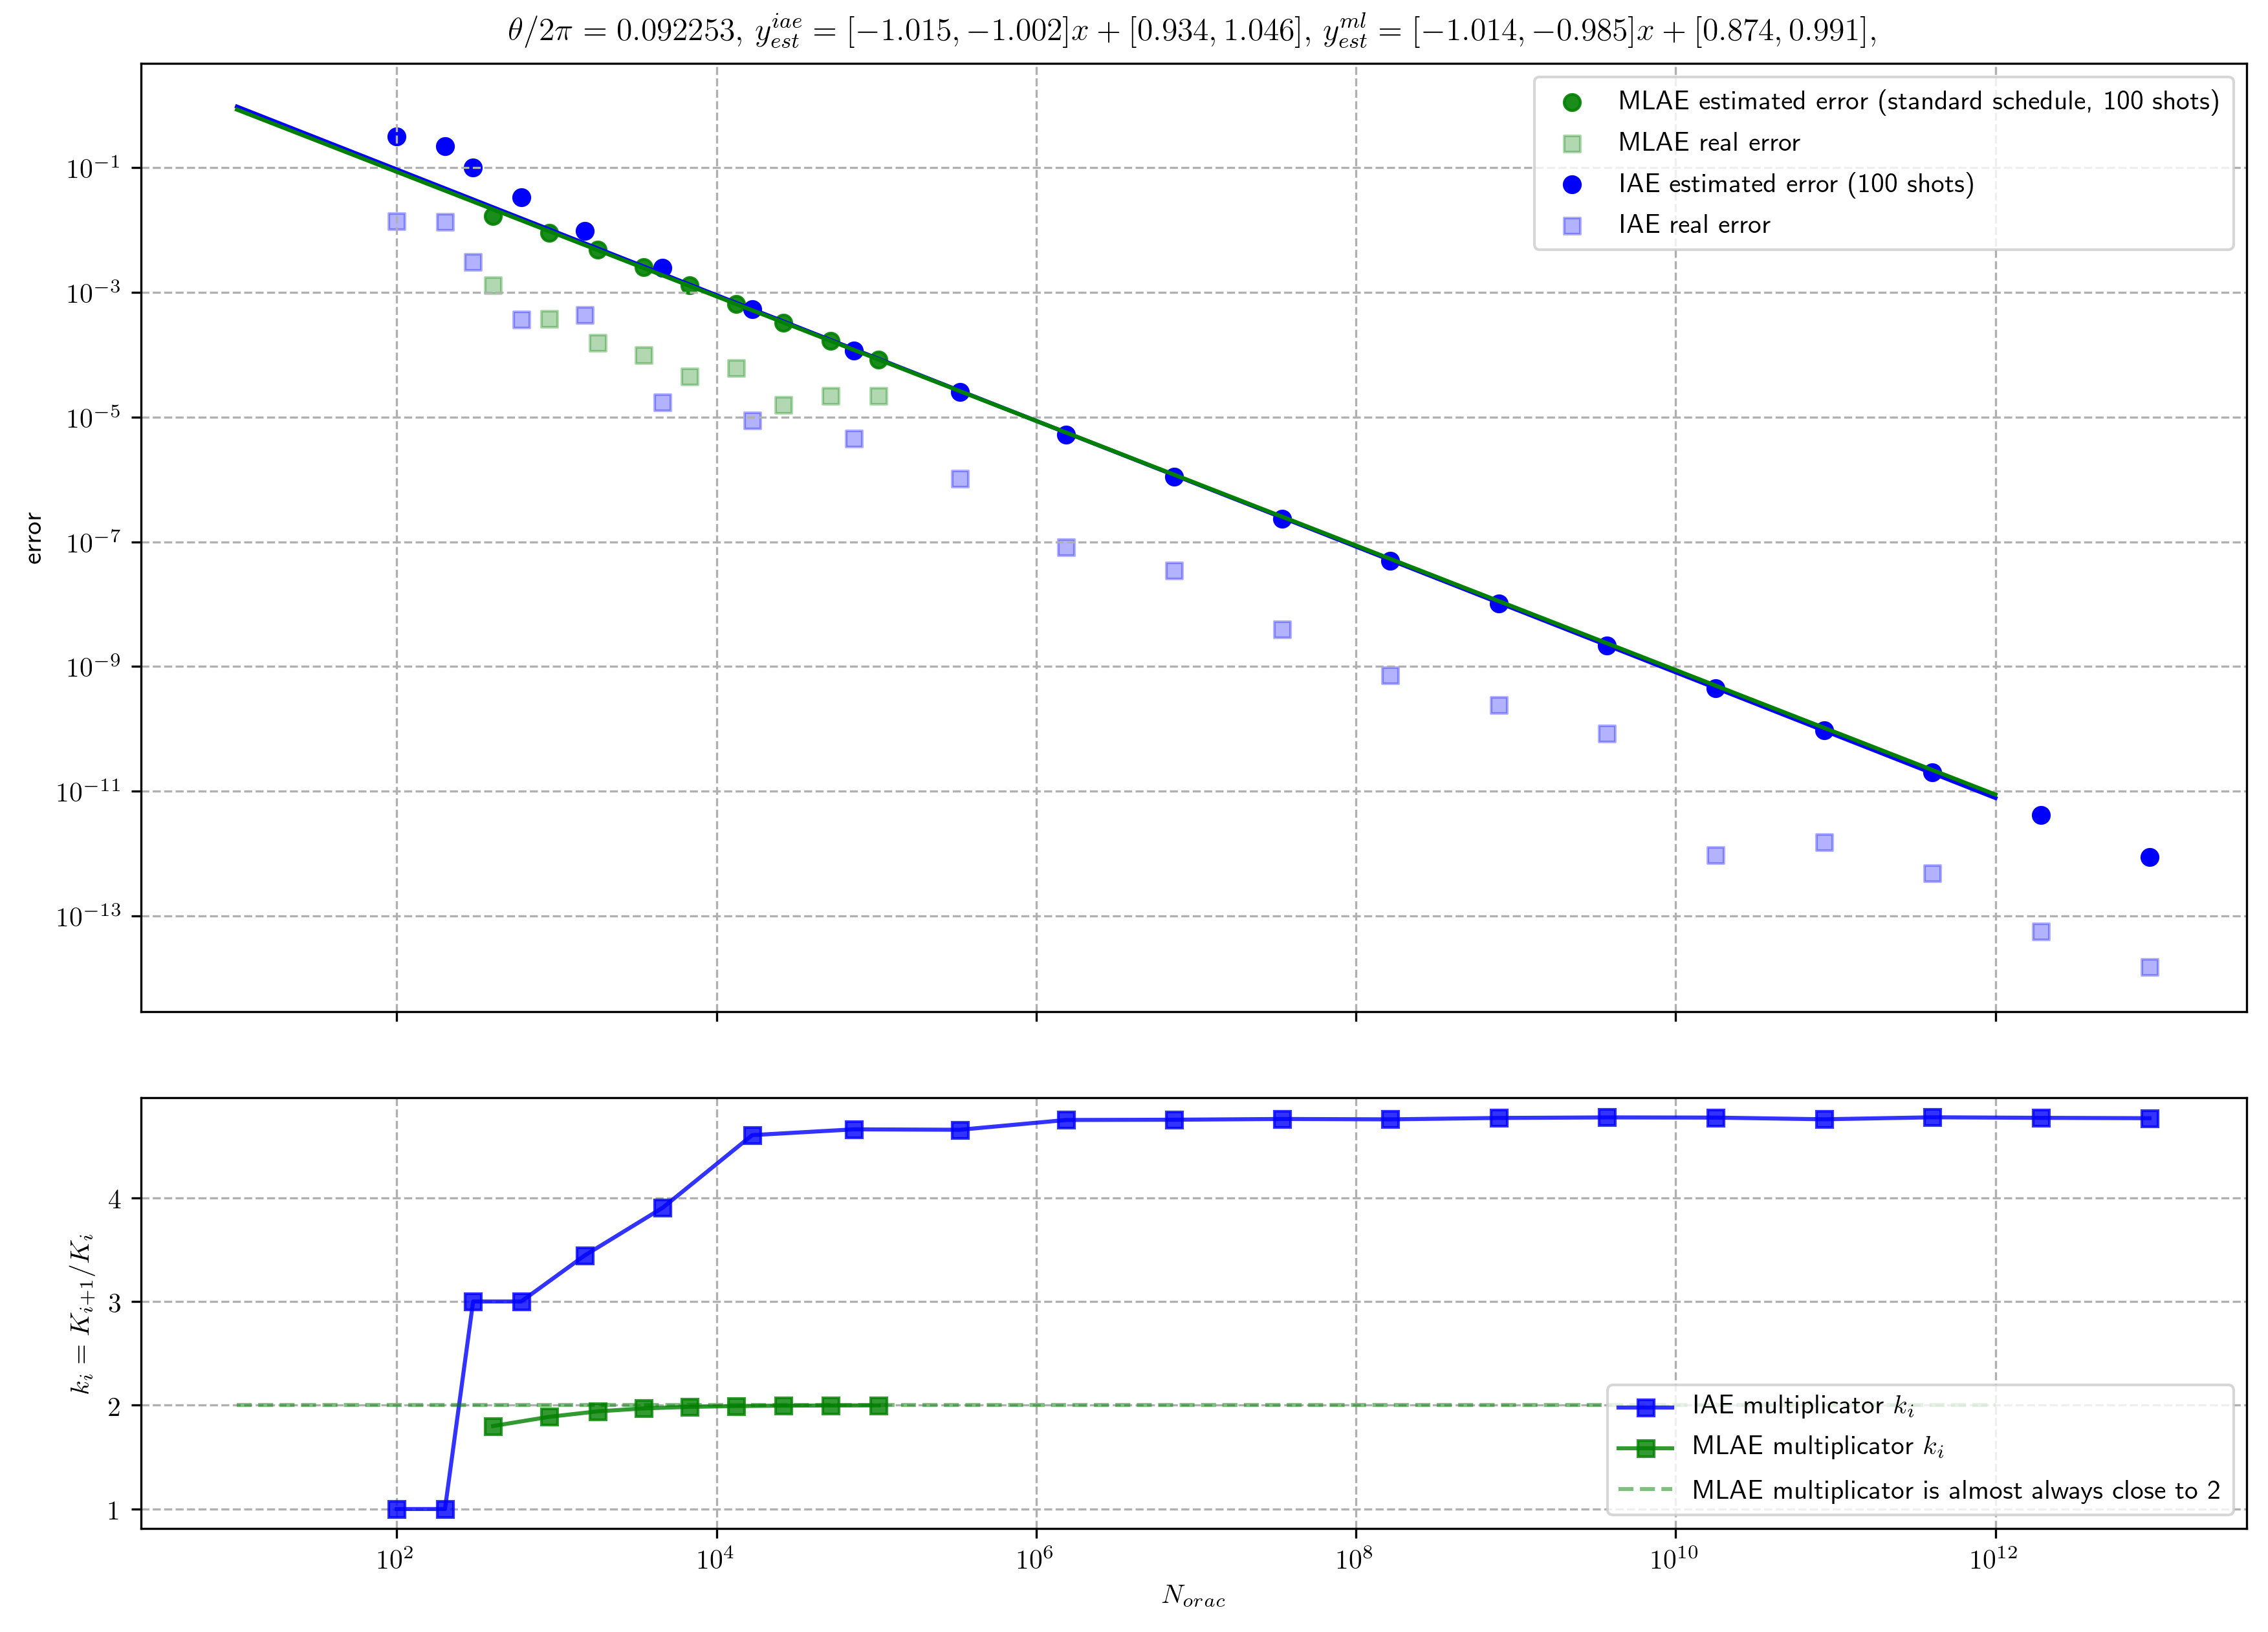

In [82]:
#plot the results

plt.rcParams['text.usetex'] = True
plt.rc('text', usetex=True)

fig = plt.figure(figsize=(14, 10), dpi=300)
grid = plt.GridSpec(3, 1, hspace=0.2, wspace=0.2)

axs = [None]*2

axs[0]=fig.add_subplot(grid[:2, 0])
axs[1]=fig.add_subplot(grid[2, 0], sharex=axs[0])

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].scatter(total_queries_mlae, error_mlae, c = 'green', alpha=0.9, label = 'MLAE estimated error (standard schedule, %d shots) '%shots)
axs[0].scatter(total_queries_mlae, error_mlae_true, c = 'green', alpha=0.3, marker='s',label = 'MLAE real error' )
axs[0].scatter(total_queries_iae, error_iae, c = 'blue', label = 'IAE estimated error (%d shots)'%shots)
axs[0].scatter(total_queries_iae, error_iae_true, c = 'blue', alpha = 0.3, marker = 's', label = 'IAE real error')
axs[0].legend(loc='upper right')
#axs[0].set_xlabel(r'$N_{orac}$')

axs[0].grid(True,which="both",ls="--")
axs[0].set_ylabel('error')

x_range = 13

model_i = OLS(np.log10(error_iae[5:]),sm.add_constant(np.log10(total_queries_iae[5:])))
results_i = model_i.fit()
x_reg = np.arange(1,x_range)
y_reg = results_i.predict(sm.add_constant(x_reg))

model_ml = OLS(np.log10(error_mlae[1:]),sm.add_constant(np.log10(total_queries_mlae[1:])))
results_ml = model_ml.fit()
x_r_ml = np.arange(1,x_range)
y_r_ml = results_ml.predict(sm.add_constant(x_r_ml))

axs[0].plot(10**x_reg, 10**y_reg, 'blue')
axs[0].plot(10**x_r_ml, 10**y_r_ml, 'green')

axs[0].set_title(r'$\theta/2\pi = %f,$ $y^{iae}_{est} = [%.3f,%.3f] x + [%.3f,%.3f],$ $y^{ml}_{est} = [%.3f,%.3f] x + [%.3f,%.3f] ,$'%
             (theta,
              results_i.conf_int(alpha=0.05)[1][0],results_i.conf_int(alpha=0.05)[1][1],
              results_i.conf_int(alpha=0.05)[0][0],results_i.conf_int(alpha=0.05)[0][1],
              results_ml.conf_int(alpha=0.05)[1][0],results_ml.conf_int(alpha=0.05)[1][1],
              results_ml.conf_int(alpha=0.05)[0][0],results_ml.conf_int(alpha=0.05)[0][1]), fontsize=12)

axs[1].set_xscale('log')
axs[1].grid(True,which="both",ls="--")
axs[1].plot(total_queries_iae, [schedule_iae[i+1]/schedule_iae[i] for i in range(len(schedule_iae)-1)],'b-',alpha=0.8,marker='s',label = 'IAE multiplicator $k_i$')
axs[1].plot(total_queries_mlae, [schedule_mlae[i+1]/schedule_mlae[i] for i in range(len(schedule_mlae)-1)],'g-',marker='s',alpha=0.8, label = 'MLAE multiplicator $k_i$')
axs[1].plot(10**(np.arange(1,x_range)), [2 for i in range(x_range-1)],'g--',alpha=0.5,label = 'MLAE multiplicator is almost always close to 2')
axs[1].set_ylabel('$k_i=K_{i+1}/K_{i}$')
axs[1].set_xlabel(r'$N_{orac}$')
axs[1].legend(loc='lower right')

plt.setp(axs[0].get_xticklabels(), visible=False)

plt.show()

### TODO MLAE - description
### TODO QAE Simplified - description
### TODO Canonical QAE with MLE - description
### TODO Comparison all vs all